In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib as mpl

import os
import re

## Helper Functions

In [58]:
def get_admittance_data(path, time_col='ros_time_sec'):
    """
    This function retrieves the admittance data for
    both Monica and Ross from the specified path.

    @param path: The path to the directory containing the csv files.
    @param time_col: The name of the time column to use for merging.
    @param norm_time_col: Whether to normalize the time column
        (subtract each timestamp from the smallest timestamp).

    """
    monica_data = pd.read_csv(os.path.join(path, 'monica_admittance_data.csv'))
    ross_data = pd.read_csv(os.path.join(path, 'ross_admittance_data.csv'))

    # save everything to a single dataframe
    time_series_df = pd.merge(
        monica_data,
        ross_data,
        on=time_col,
        how='outer',
        # appends suffixes to the column names
        # from the original dataframes
        suffixes=('_monica', '_ross')
    ).sort_values(time_col).reset_index(drop=True)

    # fill in null values
    # time_series = time_series.set_index('time_sec')
    # time_series = time_series.interpolate(method='time').reset_index()
    time_series_df = time_series_df.interpolate(method='linear')
    # fill in NaN values
    time_series_df = time_series_df.bfill()

    return time_series_df

def merge_traj_and_admittance_data(
    traj_df, admittance_df,
    time_col='ros_time_sec', tolerance=0.01,
    norm_time_col=False):
    """
    Merge the trajectory and admittance data on the time column.

    @param traj_df: The trajectory dataframe.
    @param admittance_df: The admittance dataframe.
    @param norm_time_col: Whether to normalize the time columns.
    @return: The merged dataframe.
    """

    if norm_time_col:
        traj_df[time_col] = (
            traj_df[time_col] - traj_df[time_col].min()
        ) / (traj_df[time_col].max() - traj_df[time_col].min())

        admittance_df[time_col] = (
            admittance_df[time_col] - admittance_df[time_col].min()
        ) / (admittance_df[time_col].max() - admittance_df[time_col].min())

    merged_df = pd.merge_asof(
        traj_df,
        admittance_df,
        on=time_col,
        direction='nearest',
        tolerance=tolerance
        # dataframes share no important columns
        # so this is unnecessary
        # suffixes=('_traj', '_admittance')
    )
    return merged_df


def align_trial_to_grid(df, time_col, n_samples, columns):
    """Interpolate trial data onto a normalized time grid."""
    # Time grid [0, 1]
    sample_points = np.linspace(0, 1, n_samples)
    # DataFrame to hold interpolated values
    trial_samples = pd.DataFrame({time_col: sample_points})

    # For each column,
    for col in columns:
        # Use interpolation to fill in values
        # at the sample points
        # This allows us to handle data with slightly
        # different timestamps
        trial_samples[col] = np.interp(
            sample_points,
            df[time_col],
            df[col]
        )
    return trial_samples

def get_stats(paths,
    time_col='ros_time_sec',
    n_samples=100,
    tolerance=None,
    add_nans=False):
    """
    Retrieves and computes statistics from trajectory and admittance data across multiple trials.

    @param paths: List of directories containing trial data.
    @param time_col: Name of the time column (should be normalized to [0, 1]).
    @param n_samples: Number of equally spaced samples to take per trial.
    @return: Dictionary with 'mean' and 'std' DataFrames, indexed by normalized_time.
    """
    columns_to_sample = [
        'act_ross_x', 'act_ross_y', 'act_mon_x', 'act_mon_y',
        'act_payload_x', 'act_payload_y', 'force_monica', 'force_ross'
    ]
    processed_trials = []
    original_lengths = []

    resampled_trials = []

    for trial in paths:
        # Load the data
        try:
            traj_df = pd.read_csv(os.path.join(trial, 'trajectory_data.csv'))
            admittance_df = get_admittance_data(trial, time_col=time_col)
        
        # handle missing files
        except FileNotFoundError:
            print(f"Skipping trial {trial}: Required data files not found.")
            continue

        # handle empty of malformed files
        except Exception as e:
            print(f"Skipping trial {trial}: {e}")
            continue

        # Merge trajectory and admittance data
        # normalize time column to [0, 1]
        merged_df = merge_traj_and_admittance_data(
            traj_df,
            admittance_df,
            time_col=time_col,
            tolerance=tolerance,
            norm_time_col=False
        )

        # Interpolate each column to the common time grid
        trial_samples = align_trial_to_grid(merged_df, time_col, n_samples, columns_to_sample)

        # Add the resampled trial to the list
        processed_trials.append((trial, merged_df))
        original_lengths.append(len(merged_df))

    max_length = max(original_lengths)
    resampled_trials = []

    for trial_name, merged_df in processed_trials:
            # Normalize time to [0,1] for this trial's actual length
            normalized_df = merged_df.copy()
            normalized_df[time_col] = (normalized_df[time_col] - normalized_df[time_col].min()) / \
                                    (normalized_df[time_col].max() - normalized_df[time_col].min())
            
            # Calculate what fraction of the maximum length this trial represents
            completion_fraction = len(merged_df) / max_length
            
            # Create extended time grid that goes to 1.0 even for shorter trials
            extended_time = np.linspace(0, 1, n_samples)
            
            # Find the cutoff point for this trial's actual data
            cutoff_idx = int(completion_fraction * n_samples)
            
            # Resample the actual data to the grid points it covers
            if cutoff_idx > 0:
                actual_samples = align_trial_to_grid(normalized_df, time_col, cutoff_idx, columns_to_sample)
                
                # Create full grid with NaNs
                full_samples = pd.DataFrame({
                    time_col: extended_time,
                    **{col: np.full(n_samples, np.nan) for col in columns_to_sample}
                })
                
                # Fill in the actual data
                for col in columns_to_sample:
                    full_samples.loc[:cutoff_idx-1, col] = actual_samples[col].values
                    
                resampled_trials.append(full_samples)
            else:
                print(f"Warning: Trial {trial_name} too short, skipping")
                
    # Use nanmean/nanstd since we now actually have NaNs
    stacked = np.stack([df.drop(columns=[time_col]).values for df in resampled_trials])
    time_grid = resampled_trials[0][time_col].values
    
    mean = np.nanmean(stacked, axis=0)
    std = np.nanstd(stacked, axis=0)
    
    mean_df = pd.DataFrame(mean, columns=columns_to_sample)
    std_df = pd.DataFrame(std, columns=columns_to_sample)
    mean_df.insert(0, time_col, time_grid)
    std_df.insert(0, time_col, time_grid)
    
    stats = {"mean": mean_df, "std": std_df}
    
    return stats

## Plotting Functions

In [59]:
def plot_traj_and_force(
        merged_df,
        time_col='ros_time_sec',
        fig_size=(18, 8),
        ross_color='blue',
        monica_color='red',
        payload_color='green',
        desired_line_style='-',
        actual_line_style='--'
    ):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=fig_size,
    )

    # plot trajectories
    axes[0].plot(
        merged_df['act_mon_x'],
        merged_df['act_mon_y'],
        label='Monica\'s actual trajectory',
        color=monica_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_mon_x'],
        merged_df['des_mon_y'],
        label='Monica\'s desired trajectory',
        color=monica_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_ross_x'],
        merged_df['act_ross_y'],
        label='Ross\'s actual trajectory',
        color=ross_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['des_ross_x'],
        merged_df['des_ross_y'],
        label='Ross\'s desired trajectory',
        color=ross_color,
        linestyle=desired_line_style,
        markersize=6
    )
    axes[0].plot(
        merged_df['act_payload_x'],
        merged_df['act_payload_y'],
        label='Payload\'s actual trajectory',
        color=payload_color,
        linestyle=actual_line_style,
        markersize=6
    )
    axes[0].set_xlabel('X (m)')
    axes[0].set_ylabel('Y (m)')
    axes[0].set_title('Actual Trajectories')
    axes[0].legend()
    axes[0].grid(True)

    # plot forces
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_monica'],
        label="Monica's force",
        color=monica_color
    )
    axes[1].plot(
        merged_df['act_payload_x'],
        merged_df['force_ross'],
        label="Ross's force",
        color=ross_color
    )
    axes[1].set_xlabel('Payload X Position (m)')
    axes[1].set_ylabel('Force (N)')
    axes[1].set_title('Force vs Payload X Position')
    axes[1].legend()
    axes[1].grid(True)

    fig.tight_layout()


def plot_traj_stats(mean_df, std_df, ax, traj_df=None, fig_size=(18, 8),
    xtick_left=-0.3, xtick_right=2.6, use_ylabel=True, use_xlabel=True, use_legend=True,
    ross_color='blue', monica_color='red', payload_color='green',
    desired_line_style='-', actual_line_style='--'):
    # --- Plot actual trajectories ---
    ax.plot(
        mean_df['act_mon_x'],
        mean_df['act_mon_y'],
        label="Monica's mean trajectory $\pm$ std. dev." if use_legend else None,
        color=monica_color,
        linestyle=actual_line_style,
        markersize=6
    )
    ax.fill_between(
        mean_df['act_mon_x'],
        mean_df['act_mon_y'] - std_df['act_mon_y'],
        mean_df['act_mon_y'] + std_df['act_mon_y'],
        color=monica_color,
        alpha=0.2,
        # label="Monica's std dev"
        # label="std. dev" if use_legend else None
    )
    ax.plot(
        mean_df['act_ross_x'],
        mean_df['act_ross_y'],
        label="Ross's mean trajectory $\pm$ std. dev." if use_legend else None,
        color=ross_color,
        linestyle=actual_line_style,
        markersize=6
    )
    ax.fill_between(
        mean_df['act_ross_x'],
        mean_df['act_ross_y'] - std_df['act_ross_y'],
        mean_df['act_ross_y'] + std_df['act_ross_y'],
        color=ross_color,
        alpha=0.2,
        # label="Ross's std dev"
        # label="std. dev" if use_legend else None
    )
    ax.plot(
        mean_df['act_payload_x'],
        mean_df['act_payload_y'],
        label="Payload's mean trajectory $\pm$ std. dev." if use_legend else None,
        color=payload_color,
        linestyle=actual_line_style,
        markersize=6
    )
    ax.fill_between(
        mean_df['act_payload_x'],
        mean_df['act_payload_y'] - std_df['act_payload_y'],
        mean_df['act_payload_y'] + std_df['act_payload_y'],
        color=payload_color,
        alpha=0.2,
        # label="Payload's std dev"
        # label="std. dev"
    )
    # desired trajectories
    if traj_df is not None:
        ax.plot(
            traj_df['des_mon_x'],
            traj_df['des_mon_y'],
            label="Monica's desired trajectory" if use_legend else None,
            color=monica_color,
            linestyle=desired_line_style
        )
        ax.plot(
            traj_df['des_ross_x'],
            traj_df['des_ross_y'],
            label="Ross's desired trajectory" if use_legend else None,
            color=ross_color,
            linestyle=desired_line_style
        )
    if use_xlabel:
        ax.set_xlabel('X (m)')
    if use_ylabel:
        ax.set_ylabel('Y (m)')
    ax.set_xticks(np.arange(xtick_left, xtick_right, 0.5))
    ax.set_xlim(xtick_left, xtick_right)
    # axes[0].set_title('Mean Trajectories with Std. Dev.')
    if use_legend:
        ax.legend()
    ax.grid(True)

def plot_force_stats(mean_df, std_df, ax,
    xtick_left=-0.3, xtick_right=2.6, use_ylabel=True, use_xlabel=True,
    use_legend=True,
    ross_color='blue', monica_color='red'):

    # --- Plot Monica's Forces ---
    ax.plot(
        mean_df['act_payload_x'],
        mean_df['force_monica'],
        label="Monica's mean force $\pm$ std. dev." if use_legend else None,
        color=monica_color
    )
    ax.fill_between(
        mean_df['act_payload_x'],
        mean_df['force_monica'] - std_df['force_monica'],
        mean_df['force_monica'] + std_df['force_monica'],
        color=monica_color,
        alpha=0.2,
        # label="Monica's force std dev"
    )

    # --- Plot Ross's Forces ---
    ax.plot(
        mean_df['act_payload_x'],
        mean_df['force_ross'],
        label="Ross's mean force $\pm$ std. dev." if use_legend else None,
        color=ross_color
    )
    ax.fill_between(
        mean_df['act_payload_x'],
        mean_df['force_ross'] - std_df['force_ross'],
        mean_df['force_ross'] + std_df['force_ross'],
        color=ross_color,
        alpha=0.2,
        # label="Ross's force std dev"
    )
    if use_xlabel:
        ax.set_xlabel('X (m)')
    if use_ylabel:
        ax.set_ylabel('Force (N)')
    ax.set_xticks(np.arange(xtick_left, xtick_right, 0.5))
    ax.set_xlim(xtick_left, xtick_right)
    # axes[1].set_title('Mean Forces with Std. Dev.')
    if use_legend:
        ax.legend()
    ax.grid(True)

def plot_stats(
        stats_left,
        stats_right,
        traj_df_left=None,
        traj_df_right=None,
        fig_size=(18, 8),
        ross_color='blue',
        monica_color='red',
        payload_color='green',
        desired_line_style='-',
        actual_line_style='--',
        folder_name='figures/08-30_dataset',
        file_name=None,
        font_size=14,
        font_family='Times New Roman',
        box_anchor=(0.5, 1.05)
    ):
    """
    Plots the mean and standard deviation of trajectory and force data over normalized time.

    @param stats: A dictionary containing 'mean' and 'std' DataFrames, indexed by normalized_time.
    """
    left_mean_df = stats_left['mean']
    left_std_df = stats_left['std']

    right_mean_df = stats_right['mean']
    right_std_df = stats_right['std']

    xtick_left = -0.3
    xtick_right = 2.35

    fig, axes = plt.subplots(
        nrows=4,
        ncols=1,
        figsize=fig_size,
    )

    color_legend_handles = [
        mpatches.Patch(color=monica_color, label='Monica'),
        mpatches.Patch(color=ross_color, label='Ross'),
        mpatches.Patch(color=payload_color, label='Payload')
    ]
    fig.legend(
        handles=color_legend_handles,
        loc='upper center',  # Move legend to the top bar
        bbox_to_anchor=box_anchor,  # Center above the plot
        ncol=3,  # Spread legend entries horizontally
        title='Color Association',
        framealpha=1.0
    )
    mpl.rcParams['font.size'] = font_size
    mpl.rcParams['font.family'] = font_family
    mpl.rcParams['font.weight'] = 'medium'

    # --- Trajectories (left side) ---
    plot_traj_stats(left_mean_df, left_std_df, axes[0],
        traj_df=traj_df_left,
        xtick_left=xtick_left, xtick_right=xtick_right,
        ross_color=ross_color, monica_color=monica_color,
        desired_line_style=desired_line_style,
        actual_line_style=actual_line_style,
        use_xlabel=False, use_ylabel=True,
        use_legend=False
    )

    # --- Forces (left side) ---
    plot_force_stats(left_mean_df, left_std_df, axes[1],
        xtick_left=xtick_left, xtick_right=xtick_right,
        ross_color=ross_color, monica_color=monica_color,
        use_ylabel=True, use_xlabel=False,
        use_legend=False
    )

    # --- Trajectories (right side) ---
    plot_traj_stats(right_mean_df, right_std_df, axes[2],
        traj_df=traj_df_right,
        xtick_left=xtick_left, xtick_right=xtick_right,
        use_ylabel=True, use_xlabel=False,
        ross_color=ross_color, monica_color=monica_color,
        payload_color=payload_color,
        desired_line_style=desired_line_style,
        actual_line_style=actual_line_style,
        use_legend=False
    )

    # --- Forces (right side) ---
    plot_force_stats(right_mean_df, right_std_df, axes[3],
        xtick_left=xtick_left, xtick_right=xtick_right,
        ross_color=ross_color, monica_color=monica_color,
        use_ylabel=True, use_xlabel=True, use_legend=False
    )

    fig.tight_layout()
    if file_name is not None:

        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
            
        plt.savefig(fname=f'{folder_name}/{file_name}', dpi=300)
        plt.savefig(f'{folder_name}/{file_name.replace(".png", ".eps")}',
            format='eps',
            dpi=300
        )
        plt.savefig(f'{folder_name}/{file_name.replace(".png", ".svg")}',
            format='svg',
            dpi=300
        )

## Left and right mean + std. dev plot

In [60]:
base_path = '../../data/08-30_dataset/08-30_dp_experiments/'
dirs = os.listdir(base_path)
time_col = 'ros_time_sec'
tolerance = 0.01
n_samples = 100
add_nans = True

# Match directories ending with '01' to '15'
pattern_1_to_15 = re.compile(r'01$|02$|03$|04$|05$|06$|07$|08$|09$|10$|11$|12$|13$|14$|15$')
dirs_1_to_15 = [
    os.path.join(base_path, d)
    for d in dirs
    if pattern_1_to_15.search(d)
]

# Match directories ending with '16' to '30'
pattern_16_to_30 = re.compile(r'16$|17$|18$|19$|20$|21$|22$|23$|24$|25$|26$|27$|28$|29$|30$')
dirs_16_to_30 = [
    os.path.join(base_path, d)
    for d in dirs
    if pattern_16_to_30.search(d)
]

stats_left = get_stats(
    dirs_1_to_15,
    time_col=time_col,
    n_samples=n_samples,
    tolerance=tolerance,
    add_nans=add_nans
)

stats_right = get_stats(
    dirs_16_to_30,
    time_col=time_col,
    n_samples=n_samples,
    tolerance=tolerance,
    add_nans=add_nans
)

In [61]:
# Load a representative trajectory for desired paths
traj_df_left = pd.read_csv(os.path.join(
    dirs_1_to_15[0], 'trajectory_data.csv'))
traj_df_right = pd.read_csv(os.path.join(
    dirs_16_to_30[0], 'trajectory_data.csv'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


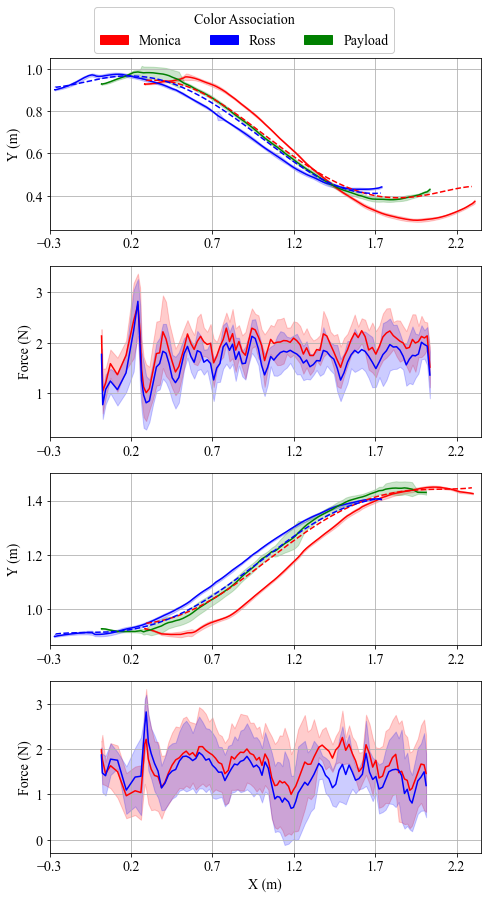

In [68]:
plot_stats(stats_left, stats_right, traj_df_left, traj_df_right, fig_size=(7, 12),
           file_name='traj_and_forces_plot_desired_traj.png',
           font_size=14,
           font_family='Times New Roman',
           desired_line_style='--', actual_line_style='-',
           box_anchor=(0.5, 1.05)
           )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


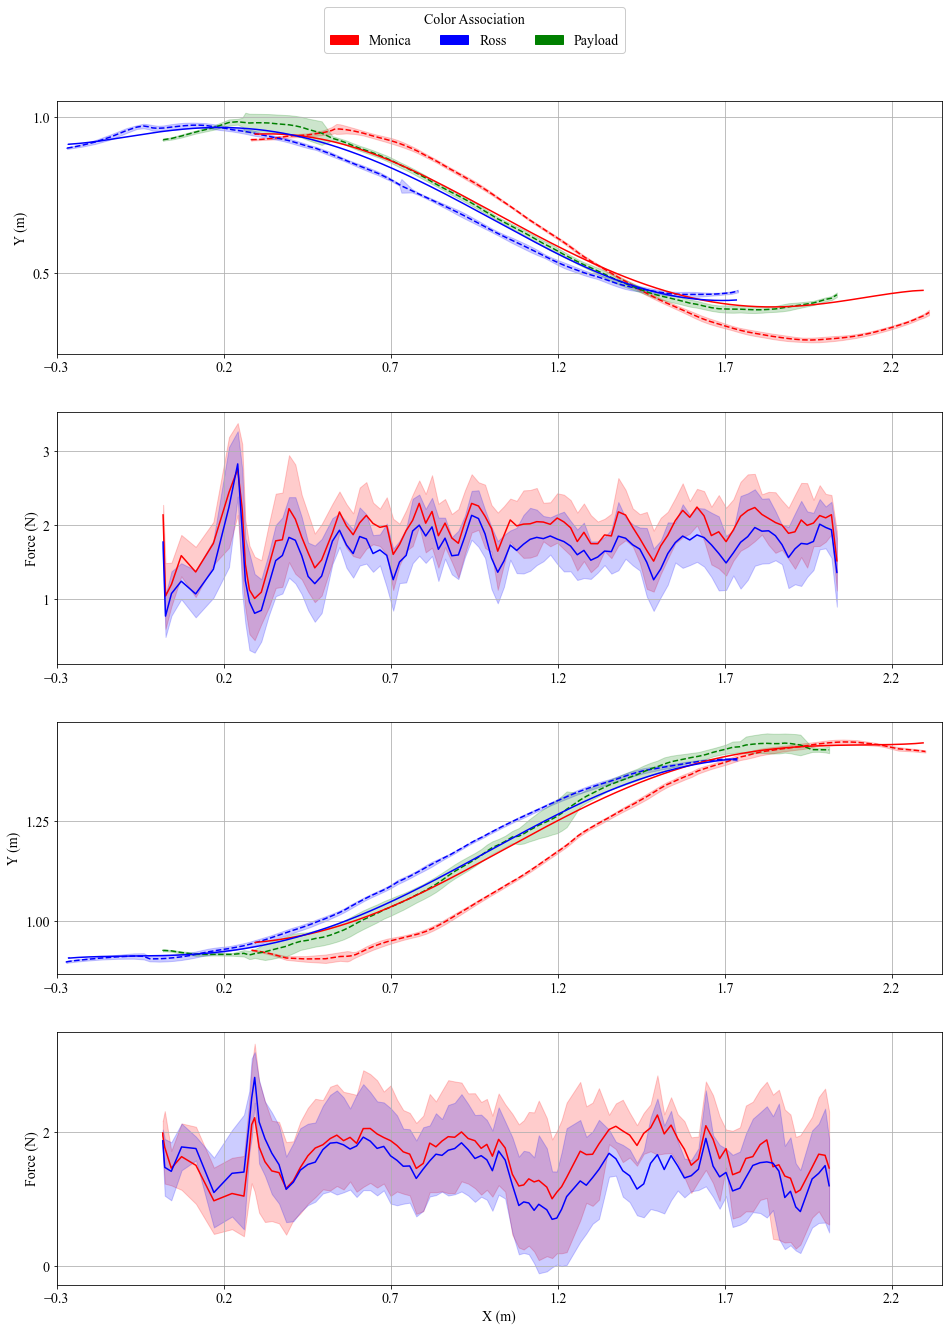

In [63]:
plot_stats(stats_left, stats_right, traj_df_left, traj_df_right, fig_size=(14, 18),
           file_name='traj_and_forces_plot_desired_traj_large.png',
           font_size=34,
           font_family='Times New Roman'
           )

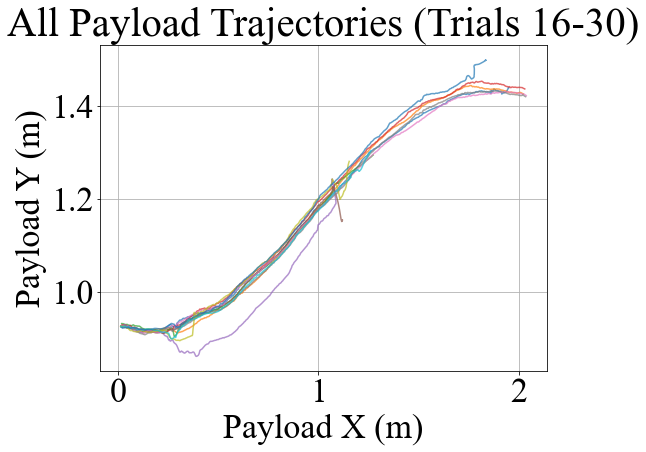

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

for trial_dir in dirs_16_to_30:
    try:
        traj_df = pd.read_csv(os.path.join(trial_dir, 'trajectory_data.csv'))
        ax.plot(traj_df['act_payload_x'], traj_df['act_payload_y'], alpha=0.7)
    except Exception as e:
        print(f"Skipping {trial_dir}: {e}")

ax.set_xlabel('Payload X (m)')
ax.set_ylabel('Payload Y (m)')
ax.set_title('All Payload Trajectories (Trials 16-30)')
ax.grid(True)
plt.show()

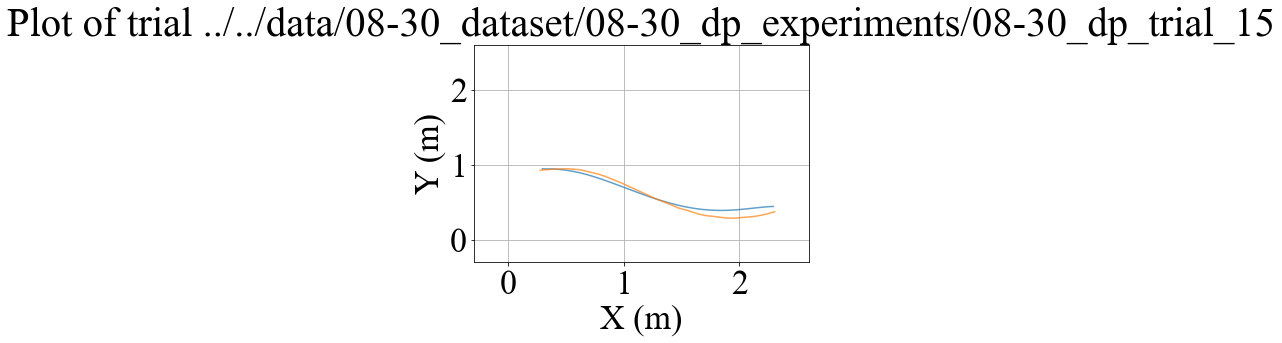

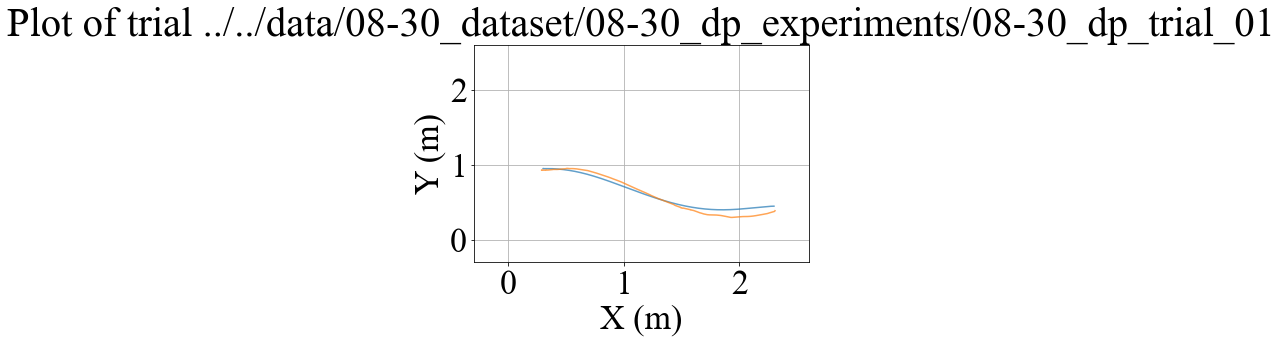

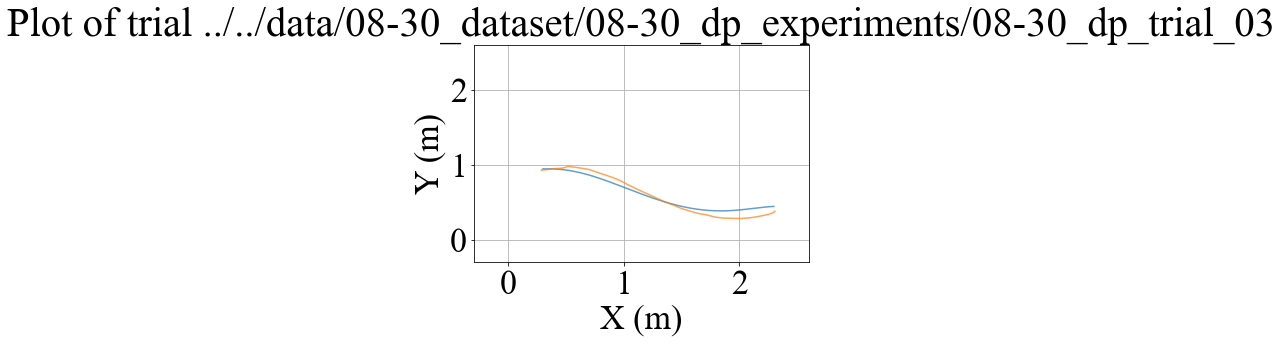

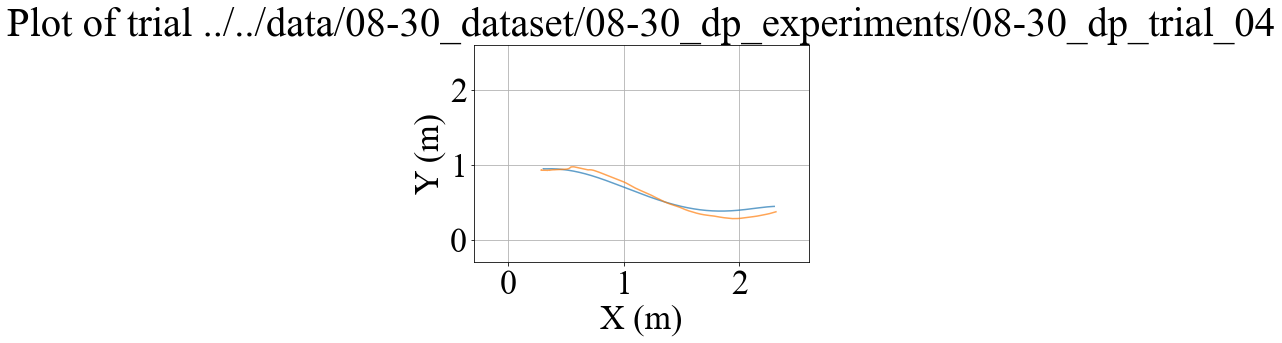

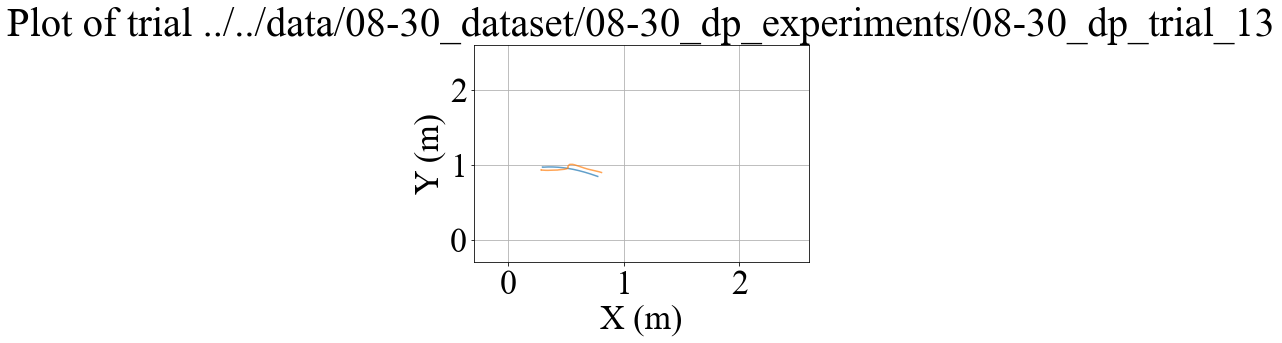

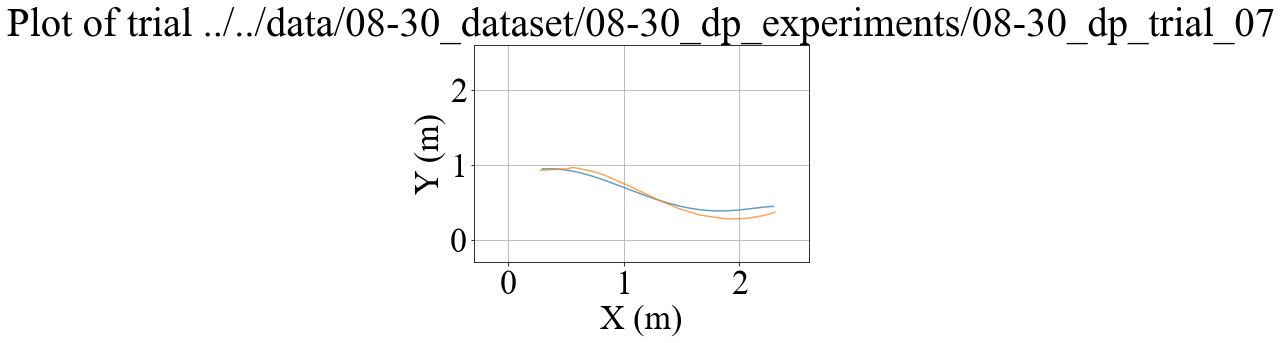

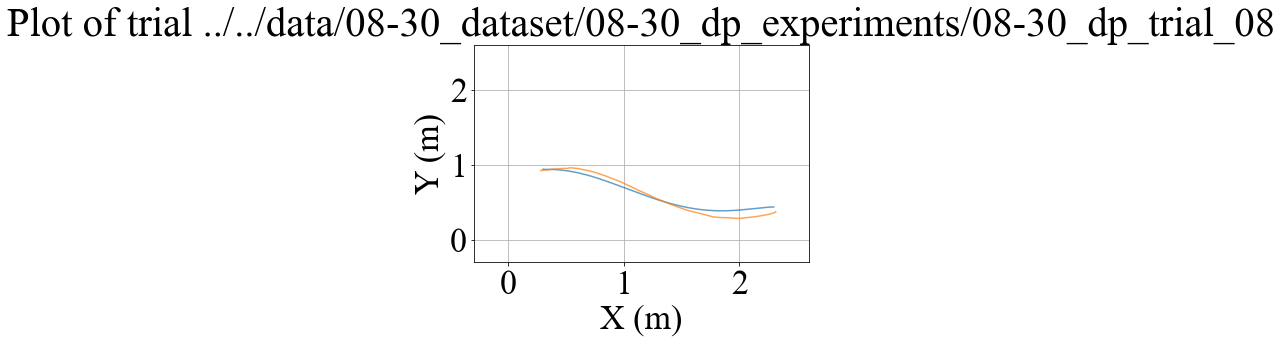

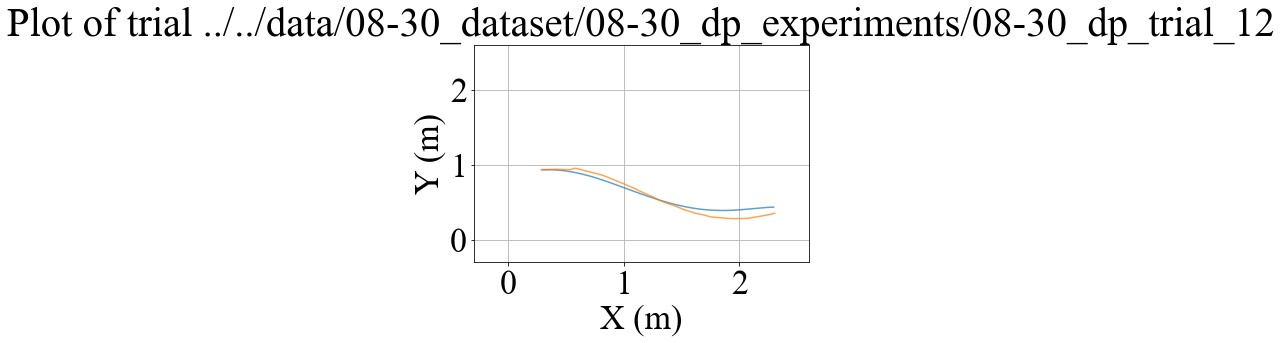

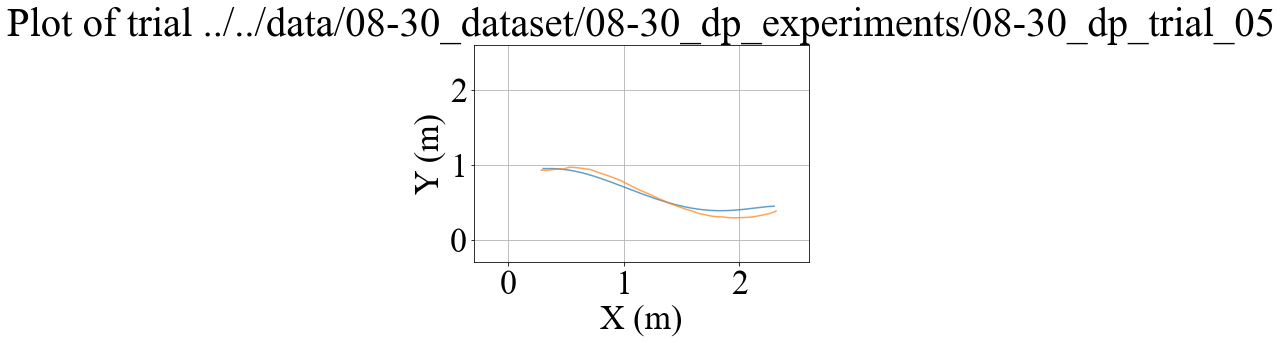

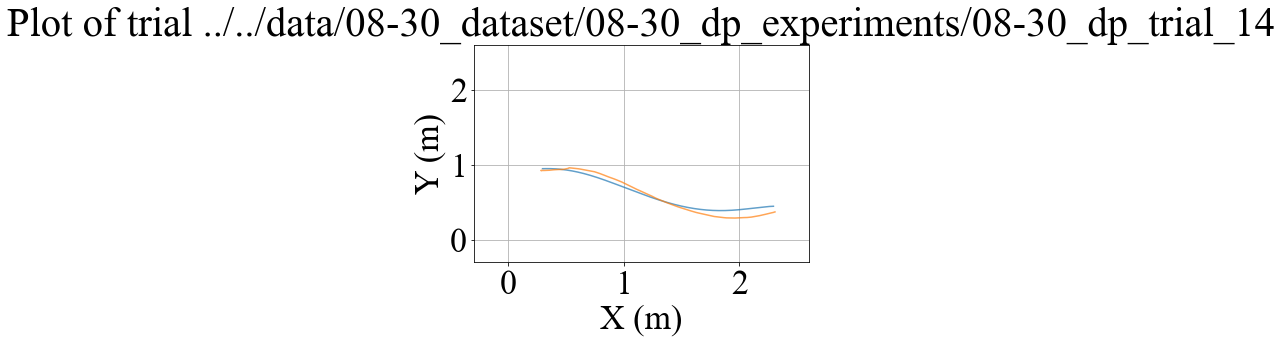

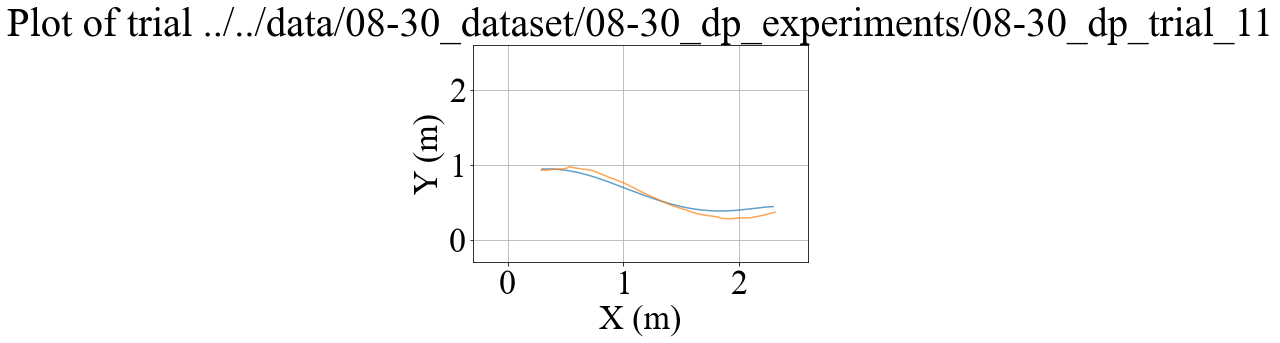

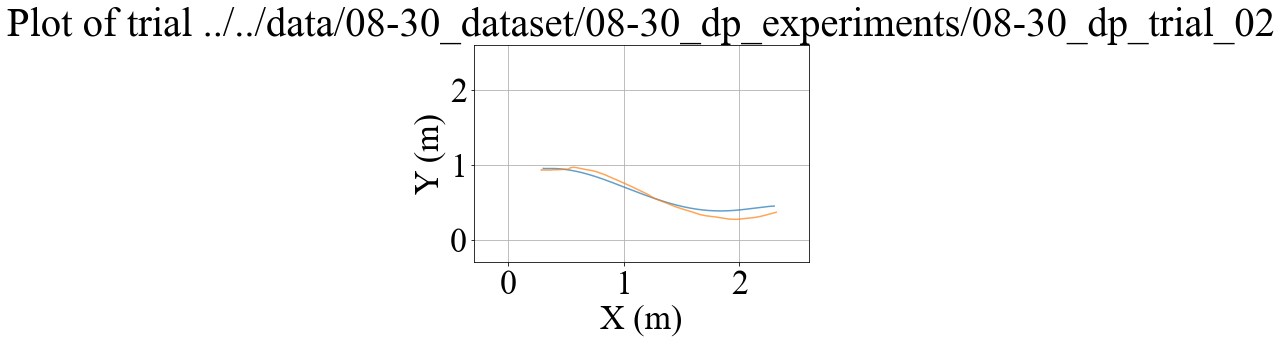

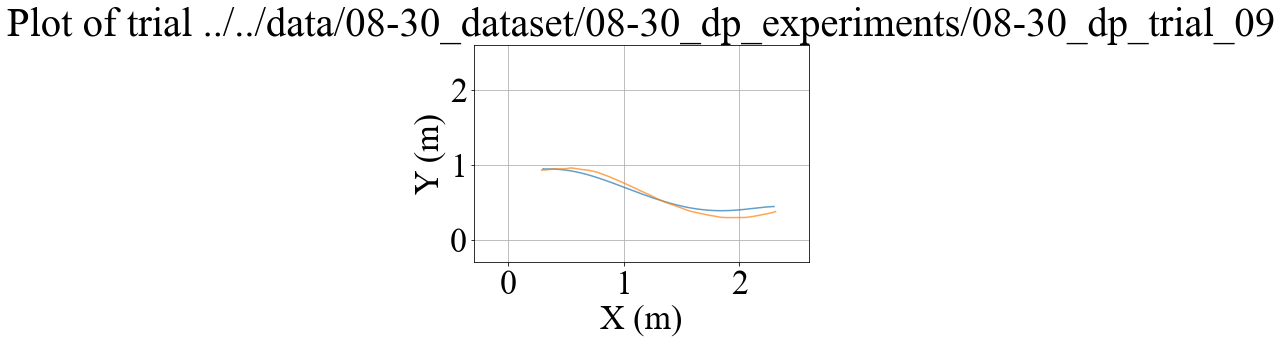

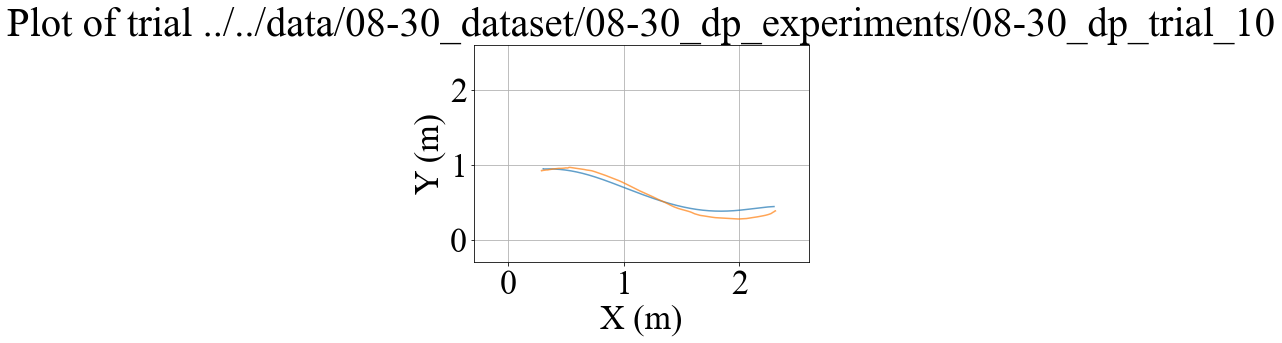

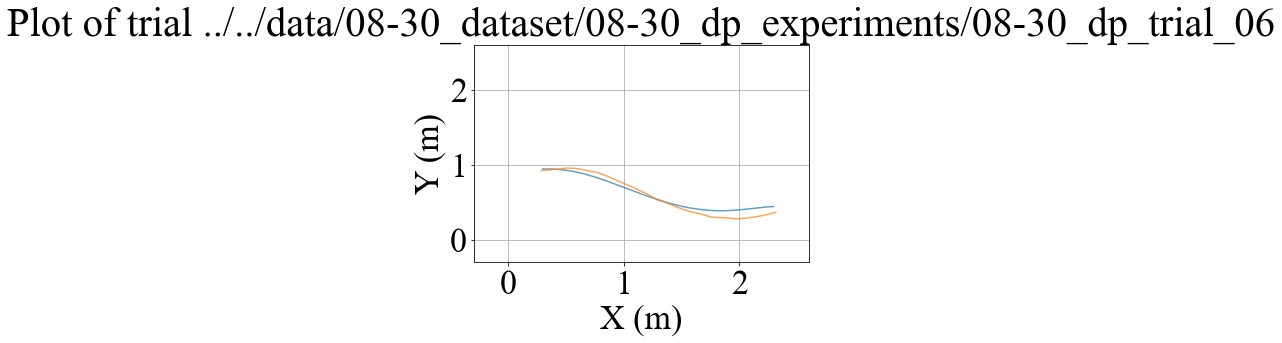

In [65]:
for trial_dir in dirs_1_to_15:
    try:
        traj_df = pd.read_csv(os.path.join(trial_dir, 'trajectory_data.csv'))
        plt.plot(traj_df['des_mon_x'], traj_df['des_mon_y'], alpha=0.7)
        plt.plot(traj_df['act_mon_x'], traj_df['act_mon_y'], alpha=0.7)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.xlim(-0.3, 2.6)
        plt.ylim(-0.3, 2.6)
        plt.title(f'Plot of trial {trial_dir}')
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Skipping {trial_dir}: {e}")

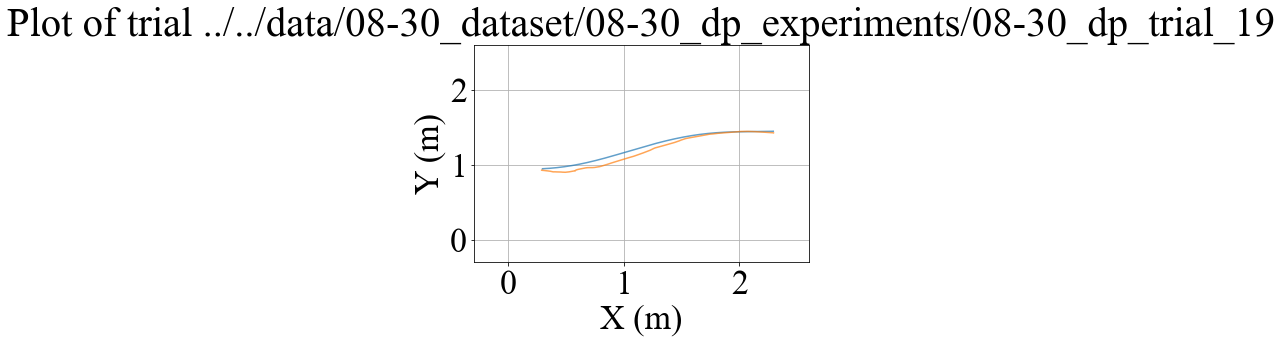

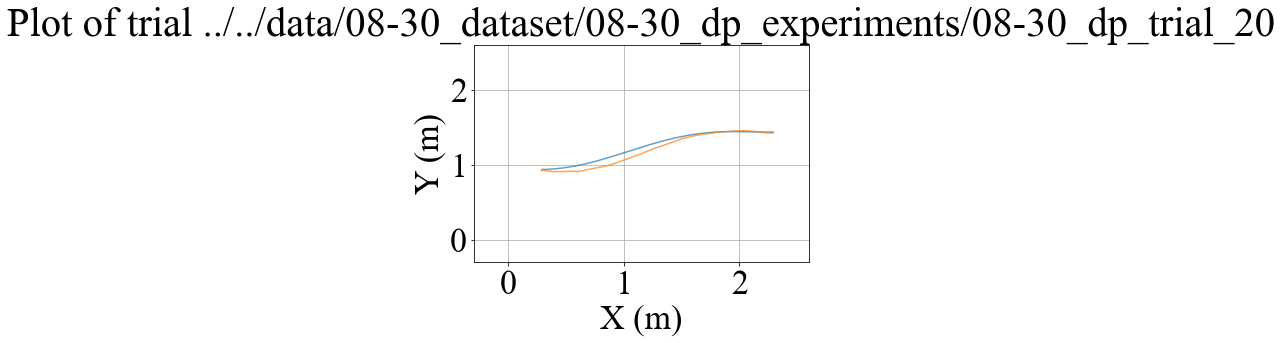

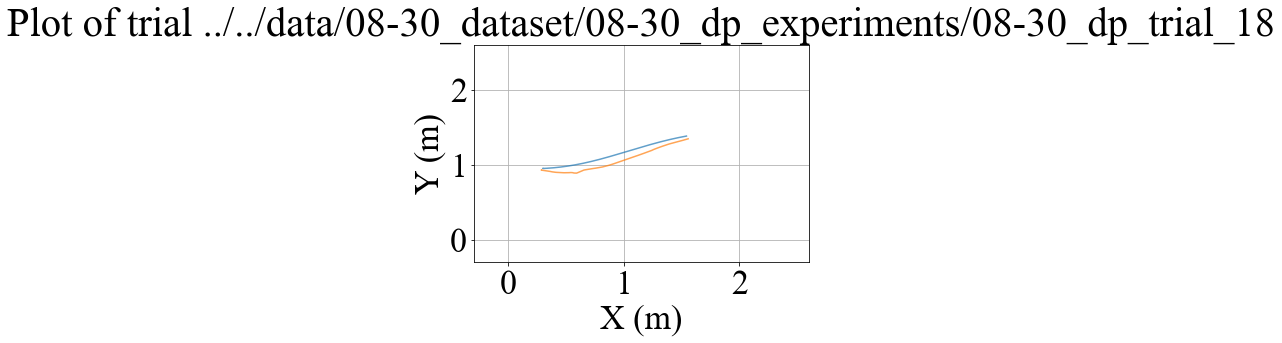

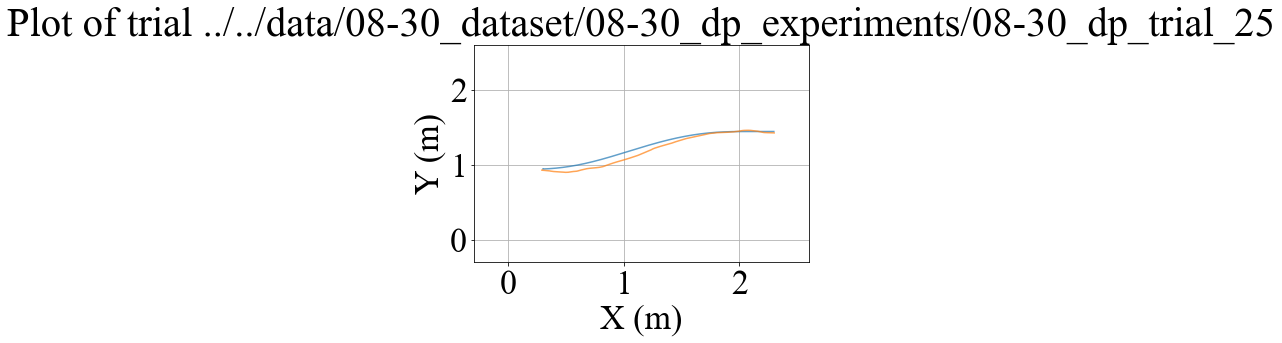

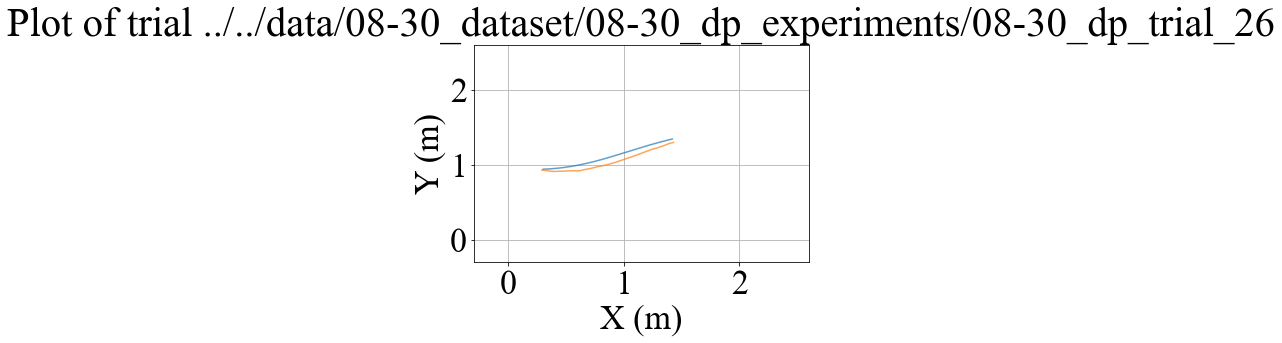

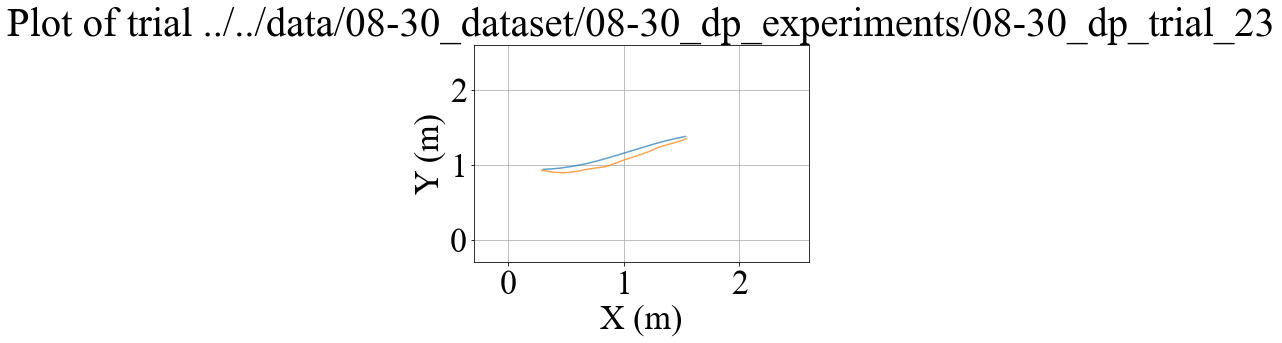

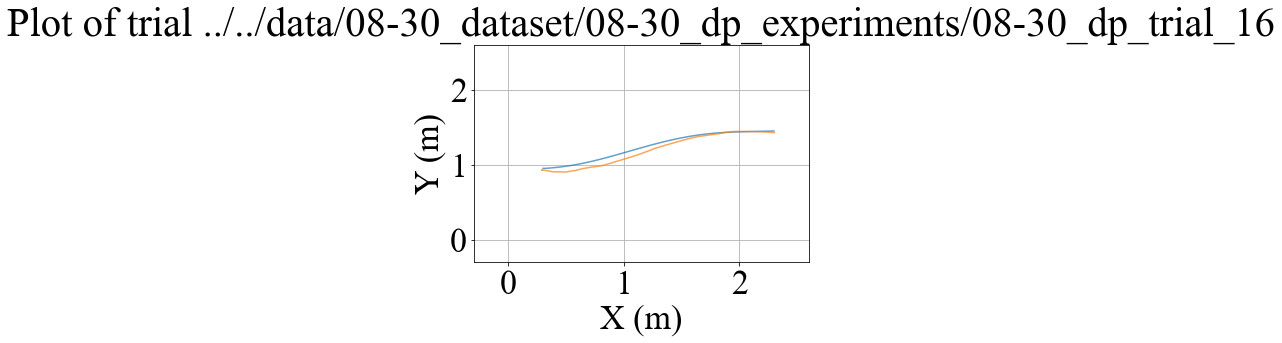

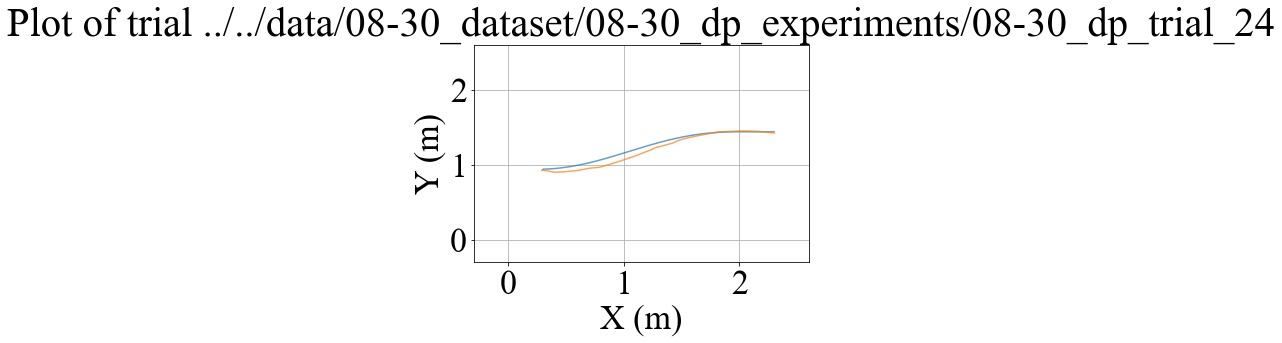

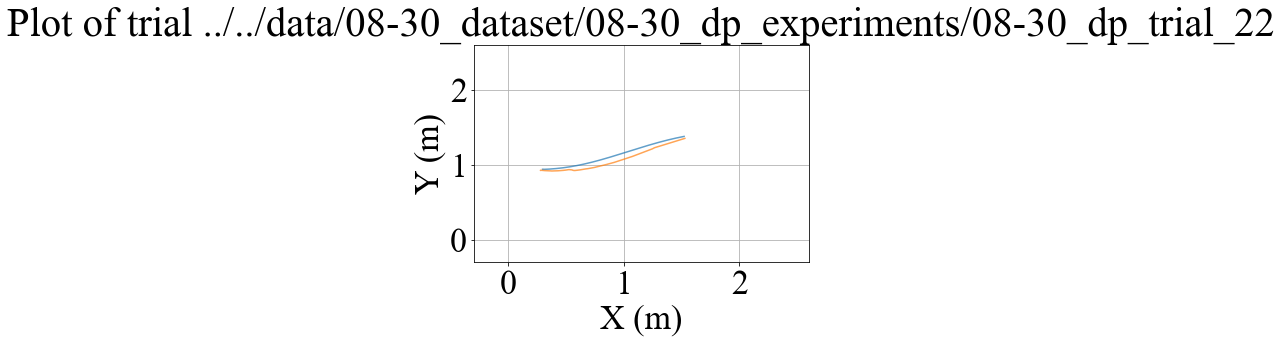

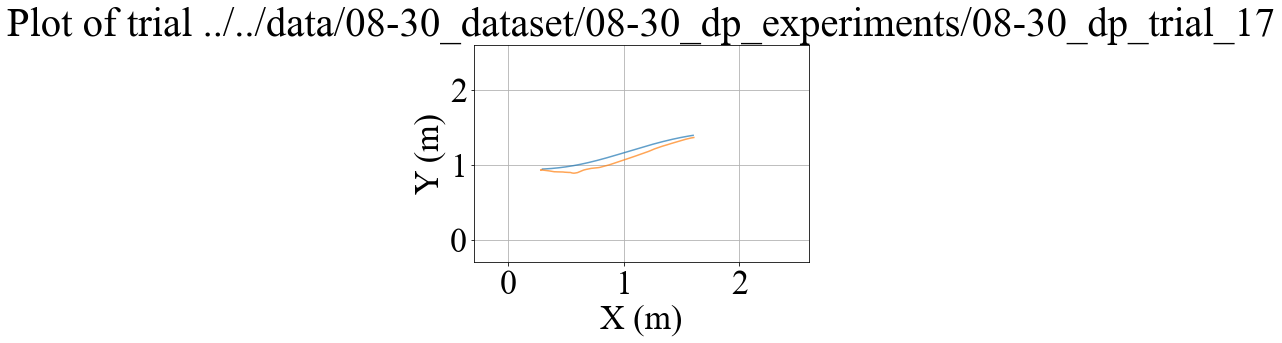

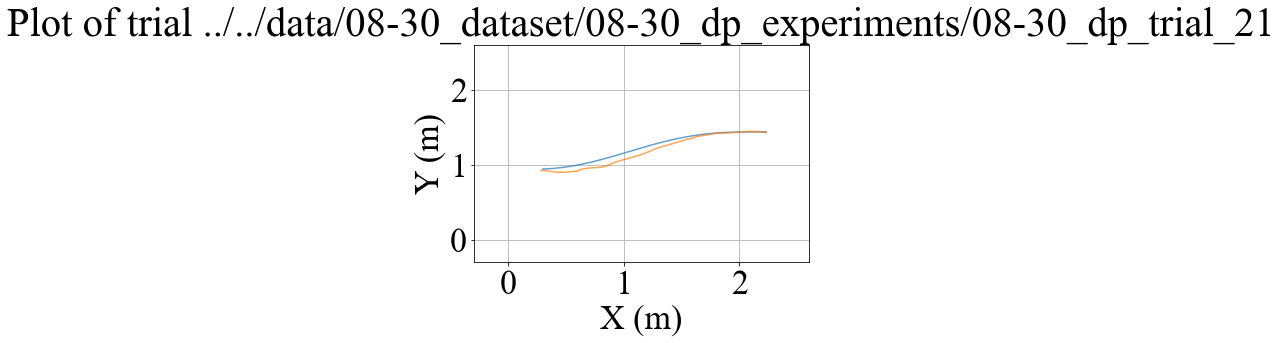

In [66]:
for trial_dir in dirs_16_to_30:
    try:
        traj_df = pd.read_csv(os.path.join(trial_dir, 'trajectory_data.csv'))
        plt.plot(traj_df['des_mon_x'], traj_df['des_mon_y'], alpha=0.7)
        plt.plot(traj_df['act_mon_x'], traj_df['act_mon_y'], alpha=0.7)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.xlim(-0.3, 2.6)
        plt.ylim(-0.3, 2.6)
        plt.title(f'Plot of trial {trial_dir}')
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Skipping {trial_dir}: {e}")

